In [4]:
# Import libraries for:

# Web scraping
import requests 
from bs4 import BeautifulSoup

# EDA
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import
from myfuncs import *

/Users/ningnong/Desktop/MADS/SIADS696_MilestoneII/Air Travel Project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# A. Data Extraction

## A1. T100 Domestic flight by origin airports (2023)
**Pros and Cons**: 
- Pro: Contains information on the actual number of departing passengers (passenger volume) from various origin airports, not just flight volume, unlike BTS data.
- Con: Only available for the year 2023, while BTS data contain flight volume for all years and thus is more comprehensive.

**Objective**:
- To show correlation between the volumes of passenger and flight, to justify the use BTS data for the analysis of air travel volume.

In [5]:
# 1. Domestic flight by origin airports (2023)
# Data: Flight volume by Airport Code; this will be our main dataset
# Extraction: csv download from https://equity-data.dot.gov/datasets/17e9a793c7cf47c8b64dab92da55dfe5/about
fp_flights = '../assets/T100_Domestic_Market_and_Segment_Data_-3591723781169319541.csv'
df_flights = pd.read_csv(fp_flights)
df_flights.columns = df_flights.columns.str.title()
df_flights.rename(columns={'Origin': 'Airport Code'}, inplace=True)
df_flights.head() #here, origin airport names ('origin') are abbreviated by the respective Airport Codes.

,Objectid,Year,Airport Code,Enplanements,Passengers,Departures,Arrivals,Freight,Mail
0,1,2023,ATL,44721151,44940145,340757,340435.0,320592384,17033732
1,2,2023,DEN,35892655,36089755,307789,307873.0,257037213,12698972
2,3,2023,DFW,33853033,33892107,297097,297129.0,442306764,22686642
3,4,2023,ORD,29305603,29379846,303030,302931.0,386208675,29107924
4,5,2023,LAS,26216256,26443518,202540,202475.0,89632420,2773334


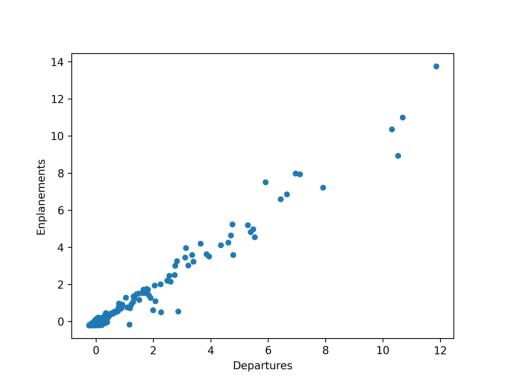

In [6]:
# 1+. EDA
# df_flights[df_flights.isna().any(axis=1)] # Mainly NA for Arrivals column

numeric_cols = ['Enplanements', 'Passengers', 'Departures', 'Arrivals', 'Freight', 'Mail']
df_flights_cleaned = df_flights[numeric_cols].dropna()

# df_flights_cleaned_sample = df_flights_cleaned.sample(100)
# sns.pairplot(df_flights_cleaned_sample[numeric_cols]) #looks to have outliers (extreme high end), let's use StandardScaler

df_flights_cleaned_normalized = df_flights_cleaned.copy()
scaler = StandardScaler()
df_flights_cleaned_normalized[numeric_cols] = scaler.fit_transform(df_flights_cleaned_normalized[numeric_cols])
df_flights_cleaned_normalized_sample = df_flights_cleaned_normalized.sample(100)

# Define temporary df for plotting
# tmp = df_flights_cleaned_normalized_sample.copy()
tmp = df_flights_cleaned_normalized.copy()

# Replot SPLOM
# sns.pairplot(tmp[numeric_cols]) 
# plt.savefig('visualizations/flights_sampled100_normalized_SPLOMs.png', dpi=300)
# plt.show()

# See the relationship between number of departing passengers vs. departed flights 
# tmp.plot(x='Departures',y='Enplanements', kind='scatter')
# plt.savefig('visualizations/flights_normalized_Enplanements_vs_Depatures.png', dpi=300)

# Load saved SPLOM
# img_name = 'flights_sampled100_normalized_SPLOMs'
img_name = 'flights_normalized_Enplanements_vs_Depatures'
img = mpimg.imread(f'visualizations/{img_name}.png')
plt.imshow(img)
plt.axis('off')
plt.show()

## A2. BTS Data

## A3. State-level features

## 3.1 FRED

In [9]:
def extract_FRED_data(url,variable):

    # Make a GET request to extract data from the url
    response = requests.get(url)
    assert response.status_code == 200, "GET Request Failed"

    # Extract table from the url
    soup = BeautifulSoup(response.text,'lxml')
    table = soup.find('table')

    # Extract headers from the table
    header_rows = table.find('thead').find_all('tr')
    main_header_row = header_rows[1] # Second header row is the main header row which actually contains headers
    headers = [header.get_text(strip=True) for header in main_header_row.find_all('th')] #Extract table header (th) elements from the main header row
    # print(headers) #['', 'Name', '2023', 'PrecedingPeriod', 'Year Agofrom Period']

    # Create a df to store data from the table with column names based on headers extracted
    df = pd.DataFrame(columns=headers[1:-1]) # Skip first (check box) and last (duplicated info with second last) headers
    # Extract data row by row
    body_rows = table.find('tbody').find_all('tr')
    for body_row in body_rows:

        row_data = [] # to store data element-wise
        state_name = body_row.find('th').find('span',class_='fred-rls-elm-nm').get_text(strip=True)
        values = [value.get_text(strip=True) for value in body_row.find_all('td', class_='fred-rls-elm-vl-td')[:-1]] # Skip the last element; extract 2023 and 2022 data
        row_data.append(state_name)
        row_data += values
        
        # Append new data row to df
        length = len(df)
        df.loc[length] = row_data
    df.rename(columns= {
        'Name':'State Name',
        '2023': f'{variable} (2023)',
        'PrecedingPeriod': f'{variable} (2022)'      
    }, inplace=True)

    value_cols = [f'{variable} (2023)',f'{variable} (2022)']
    for value_col in value_cols:
        df[value_col] = df[value_col].str.replace(',','').astype(float)

    return df

### 3.1.1 Income

In [10]:
# Data: Median household income by state (2022, 2023)
# Extraction: GET
url = 'https://fred.stlouisfed.org/release/tables?rid=249&eid=259462' # Median household income by state
variable = 'Median Household Income'
income_df = extract_FRED_data(url,variable)
income_df.head()

# response = requests.get(url)
# assert response.status_code == 200
# soup = BeautifulSoup(response.text, 'lxml')
# table = soup.find('table')
# # rows = table.find_all('tr')

# # Extract headers
# header_row = table.find('thead').find_all('tr')[1] # Extract second header row which contains the headers
# headers = [header.get_text(strip=True) for header in header_row.find_all('th')]
# # print(headers) #['', 'Name', '2023', 'PrecedingPeriod', 'Year Agofrom Period']

# income_df = pd.DataFrame(columns=headers[1:-1]) #skip the first and the last (same info as second last)
# body_rows = table.find('tbody').find_all('tr')
# for body_row in body_rows:
#     length = len(income_df)
#     row_data = []
#     state_name = body_row.find('th').find('span', class_='fred-rls-elm-nm').get_text(strip=True)
#     incomes = body_row.find_all('td', class_='fred-rls-elm-vl-td')[:-1] #skip the last element; extract 2023 and 2022 income data
#     income_data = [income.get_text(strip=True) for income in incomes]
#     row_data.append(state_name)
#     row_data += income_data
#     # print(row_data)
#     income_df.loc[length] = row_data
# income_df.rename(columns={
#     'Name':'State Name',
#     '2023':'Median Household Income (2023)',
#     'PrecedingPeriod': 'Median Household Income (2022)'
# }, inplace=True)


# income_cols = ['Median Household Income (2023)','Median Household Income (2022)']
# for income_col in income_cols:
#     income_df[income_col] = income_df[income_col].str.replace(',','').astype(int)

# income_df.head()
# # income_df.info()

,State Name,Median Household Income (2023),Median Household Income (2022)
0,The United States,NaN,NaN
1,Alabama,NaN,NaN
2,Alaska,NaN,NaN
3,Arizona,NaN,NaN
4,Arkansas,NaN,NaN


### 3.1.2 Unemployment

In [ ]:
# Data: 

url = 'https://fred.stlouisfed.org/release/tables?eid=840687&rid=116'
response = requests.get(url)
assert response.status_code == 200
soup = BeautifulSoup(response.text, 'lxml')
table = soup.find('table')
# rows = table.find_all('tr')

# Extract headers
header_row = table.find('thead').find_all('tr')[1] # Extract second header row which contains the headers
headers = [header.get_text(strip=True) for header in header_row.find_all('th')]
# print(headers) #['', 'Name', '2023', 'PrecedingPeriod', 'Year Agofrom Period']

UE_df = pd.DataFrame(columns=headers[1:-1]) #skip the first and the last (same info as second last)
body_rows = table.find('tbody').find_all('tr')
for body_row in body_rows:
    length = len(UE_df)
    row_data = []
    state_name = body_row.find('th').find('span', class_='fred-rls-elm-nm').get_text(strip=True)
    UEs = body_row.find_all('td', class_='fred-rls-elm-vl-td')[:-1] #skip the last element; extract 2023 and 2022 UE data
    UE_data = [UE.get_text(strip=True) for UE in UEs]
    row_data.append(state_name)
    row_data += UE_data
    # print(row_data)
    UE_df.loc[length] = row_data
UE_df.rename(columns={
    'Name':'State Name',
    '2023':'Median Household UE (2023)',
    'PrecedingPeriod': 'Median Household UE (2022)'
}, inplace=True)


UE_cols = ['Median Household UE (2023)','Median Household UE (2022)']
for UE_col in UE_cols:
    UE_df[UE_col] = UE_df[UE_col].str.replace(',','').astype(float)

UE_df.head()

,State Name,Median Household UE (2023),Median Household UE (2022)
0,Alabama,2.5,2.5
1,Alaska,4.2,4.2
2,Arizona,3.9,3.8
3,Arkansas,3.3,3.2
4,California,4.8,4.3


## 3.2 USCB (US Census Bureau)

<Figure size 640x480 with 0 Axes>

In [ ]:
# 3. Mapper for airport code to airport name
# Data: Mapper for Airport Code, Airport Name, City, State (by State Code)
# Extraction: get from https://www.transtats.bts.gov/ONTIME/AirportInfo.html
url = 'https://www.transtats.bts.gov/ONTIME/AirportInfo.html'
response = requests.get(url)
assert response.status_code == 200
soup = BeautifulSoup(response.text, 'lxml')
# soup = BeautifulSoup(response.content, 'html.parser')
# print(soup.prettify())

table = soup.find('table')
rows = table.find_all('tr')

# Extract table data into a df
header_row = rows[0]
headers = [th.get_text(strip=True) for th in header_row.find_all('th')]
df_airports = pd.DataFrame(columns=headers)
for row in rows[1:]: #skip header row
    row_data = [td.get_text(strip=True) for td in row.find_all('td')]
    newrow_idx = len(df_airports) # newrow_idx = [lastrow_idx] +1 = [len(df)-1] +1 = len(df)
    df_airports.loc[newrow_idx] = row_data
# df_airports
col_name = 'Airport/City/State Name'
# df_airports[col_name] = df_airports['Airport/City/State Name'].str.strip().str.rstrip(',') #doesn't work, still have additional column of "None" values -> use n=2 instead
new_cols = col_name.split('/') # Expand Airport/City/State Name into three separate columns
df_airports[new_cols] = df_airports[df_airports.columns[1]].str.split(',', n=2, expand=True) #splits the string only at the first two commas
df_airports.drop(columns=[col_name],inplace=True)
df_airports.rename(columns={
    'State Name':'State Code',
    'Airport': 'Airport Name'
    }, inplace=True
)
df_airports

,Airport Code,Airport Name,City,State Code
0,ABE,Lehigh Valley International,Allentown,PA
1,ABI,Abilene Regional,Abilene,TX
2,ABQ,Albuquerque International,Albuquerque,NM
3,ACK,Nantucket Memorial,Nantucket,MA
4,ADQ,Kodiak,Kodiak,AK
...,...,...,...,...
220,TWF,Joslin Field-Magic Valley Regional,Twin Falls,ID
221,TYS,McGhee Tyson,Knoxville,TN
222,VPS,Eglin Air Force Base,Valparaiso,FL
223,WRG,Wrangell,Wrangell,AK


In [ ]:
# 4. Mapper for US State Code to State Name